In [1]:
import brightway2 as bw
import os               # to use "operating system dependent functionality"
import numpy as np      # "the fundamental package for scientific computing with Python"
import pandas as pd     # "high-performance, easy-to-use data structures and data analysis tools" for Python
import csv
import stats_arrays
import scipy as sp
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
bw.projects.set_current('iw_integration')

In [4]:
bw.bw2setup()

Biosphere database already present!!! No setup is needed


First you have to add the generalized beta distribution in stats_array, following the corresponding notebook.

Loading CFs with uncertainty information for csv file. All ef_UUIDs correspond to elementary flows as defined in OpenLCA and classified for IMPACT World+. UUID in OpenLCA and BW2 are the same, nevertheless it exists additionnal elementary flows in OpenLCA. Therefore there are several elementary flows in the list that will not be relevant for the integration in BW2.

In [4]:
path_to_input_csv=r'C:\bw2-python\Notebook - tutorial\IW+ integration\Files\All IC regionalized_with uncertainty.csv'
iw_olca_uncert = csv.DictReader(open(path_to_input_csv, "r"), delimiter=";")
iw_olca_uncert_list=[cf for cf in iw_olca_uncert]
iw_olca_uncert_dict={(cf['impact_cat_name'],cf['ef_UUID']):cf for cf in iw_olca_uncert_list}
iw_olca_uncert_dict

{('Freshwater acidification, GLO, with uncert',
  '003697f1-54e9-409e-8179-23a95e99e4d7'): {'CF_formula': '0.799194406',
  'CF_per_unit_name': 'kg',
  'CF_unit': 'PDF.m2.yr',
  'IW_Sample_CF_Max': '93.83769727',
  'IW_Sample_CF_Mean': '0.799247818',
  'IW_Sample_CF_Min': '0.002406182',
  'IW_Sample_CF_Std dev': '1.35155162',
  'IW_Sample_CF_Variance': '1.826691782',
  'IW_ef': 'NOx',
  'Stoechiometric_ratio': '1',
  'beta_param_alpha': '0.336155493',
  'beta_param_beta': '39.24918627',
  'beta_param_max': '93.83769727',
  'beta_param_min': '0.002406182',
  'ef_UUID': '003697f1-54e9-409e-8179-23a95e99e4d7',
  'flow_category_subcompart': 'low population density',
  'flow_name': 'Nitrogen dioxide',
  'impact_cat_name': 'Freshwater acidification, GLO, with uncert',
  'impact_method_name': 'IMPACTWorld+ - Endpoint - only with spatial variability',
  'uncert_param1': '0',
  'uncert_param2': '0.799194406',
  'uncert_param3': '93.83769727',
  'uncert_type_name': 'triangle'},
 ('Freshwater acid

Here is the error found when performing Monte Carlo analysis

---------------------------------------------------------------------------
MaximumIterationsError                    Traceback (most recent call last)
<ipython-input-35-90425dfde9bb> in <module>()
      6 iterations = 10
      7 
----> 8 scores=MC_multi_impact(fu_tuple,list_methods_name,iterations)
      9 scores

<ipython-input-11-eeb51539d7b1> in MC_multi_impact(fu_tuple, list_methods_name, iterations)
     11         print(ic)
     12         MC_results_per_IC = bw.MonteCarloLCA(fu_dict,ic)
---> 13         scores = [next(MC_results_per_IC) for _ in range(iterations)]
     14         MC_results_dict[ic]=scores
     15 

<ipython-input-11-eeb51539d7b1> in <listcomp>(.0)
     11         print(ic)
     12         MC_results_per_IC = bw.MonteCarloLCA(fu_dict,ic)
---> 13         scores = [next(MC_results_per_IC) for _ in range(iterations)]
     14         MC_results_dict[ic]=scores
     15 

C:\bw2-python\envs\bw2\lib\site-packages\bw2calc\monte_carlo.py in __next__(self)
     95         self.rebuild_biosphere_matrix(self.bio_rng.next())
     96         if self.lcia:
---> 97             self.rebuild_characterization_matrix(self.cf_rng.next())
     98         if self.weighting:
     99             self.weighting_value = self.weighting_rng.next()

C:\bw2-python\envs\bw2\lib\site-packages\stats_arrays\random.py in next(self)
    181                 1,
    182                 self.random,
--> 183                 self.maximum_iterations
    184             )
    185             if len(random_data.shape) == 2:

C:\bw2-python\envs\bw2\lib\site-packages\stats_arrays\distributions\base.py in bounded_random_variables(cls, params, size, seeded_random, maximum_iterations)
    210             counter += 1
    211             if counter >= maximum_iterations:
--> 212                 print(str(maximum_iterations))
    213                 raise MaximumIterationsError
    214         return data

MaximumIterationsError: 

## Creating uncertainty dictionaries for each CFs

The priority order for the choice of distribution is : 1- Generalized Beta distribution if alpha and beta positive or No distribution if specified 2- if alpha and beta negative, Triangular distribution with moment method 3- if mode_triangular<minimum, Bounded Normal with moment method (no problem with negative CFs)

In [5]:
def uncert_dict_triang_moment_method(sample_min,sample_mean,sample_max):
    
    mode = 3 * sample_mean - sample_min - sample_max
    
    if mode < sample_min:
        uncert_dict={'amount': sample_mean,
                'uncertainty type': stats_arrays.NoUncertainty.id};
    else:
        uncert_dict={'amount': sample_mean,
                'loc': mode,
                'maximum': sample_max,
                'minimum': sample_min,
                'uncertainty type': stats_arrays.TriangularUncertainty.id};
        
    return uncert_dict;
    

In [6]:
from stats_arrays import MCRandomNumberGenerator, UncertaintyBase


def test_distrib(ID,uncert_dict):
    params_distrib = UncertaintyBase.from_dicts(uncert_dict)
    mcrng_distrib = MCRandomNumberGenerator(params_distrib)
    try:
        mcrng_distrib.next()
        return None
    except:
        tuple_error=(ID,uncert_dict)
        return tuple_error


In [7]:
iw_uncert_dict_beta={}
iw_uncert_beta_distrib={}
iw_uncert_none_distrib={}
iw_uncert_triang_distrib={}
iw_uncert_normal_distrib={}

list_error_generalized_beta=[]
list_error_triang=[]
list_error_normal=[]

i=0

for cf in iw_olca_uncert_dict:
    
    i=i+1
    
    amount=float(iw_olca_uncert_dict[cf]['CF_formula'])
    uncert_type=iw_olca_uncert_dict[cf]['uncert_type_name']
    
    if uncert_type.lower()=="none":
        uncert_dict=amount
        iw_uncert_dict_beta[cf]=uncert_dict
        iw_uncert_none_distrib[cf]=uncert_dict
        continue
    else:        
        alpha=float(iw_olca_uncert_dict[cf]['beta_param_alpha'])
        beta=float(iw_olca_uncert_dict[cf]['beta_param_beta'])
        minimum=float(iw_olca_uncert_dict[cf]['beta_param_min'])
        maximum=float(iw_olca_uncert_dict[cf]['beta_param_max'])
        mean=float(iw_olca_uncert_dict[cf]['IW_Sample_CF_Mean'])
        variance=float(iw_olca_uncert_dict[cf]['IW_Sample_CF_Variance'])
        mode_triang = 3 * mean - minimum - maximum
    
    if alpha>0 and beta>0:
        uncert_dict={'amount': amount,
                          'loc': alpha, 
                          'shape': beta, 
                          'maximum': maximum,
                          'minimum': minimum,
                          'uncertainty type': stats_arrays.GeneralizedBetaUncertainty.id,'uncertainty_type': stats_arrays.GeneralizedBetaUncertainty.id}
        iw_uncert_dict_beta[cf]=uncert_dict
        iw_uncert_beta_distrib[cf]=uncert_dict
        if test_distrib(cf,uncert_dict)!= None:
            list_error_generalized_beta.append(test_distrib(cf,uncert_dict))
        continue
     
    elif mode_triang >= minimum:
        uncert_dict=uncert_dict_triang_moment_method(minimum,mean,maximum)
        iw_uncert_dict_beta[cf]=uncert_dict
        iw_uncert_triang_distrib[cf]=uncert_dict
        if test_distrib(cf,uncert_dict)!= None:
            list_error_triang.append(test_distrib(cf,uncert_dict))
        continue
    
    else:
        uncert_dict={'amount': amount,
                          'loc': mean, 
                          'scale': np.sqrt(np.abs(variance)), 
                          'maximum': maximum,
                          'minimum': minimum,
                          'uncertainty type': stats_arrays.NormalUncertainty.id}
        iw_uncert_dict_beta[cf]=uncert_dict
        iw_uncert_normal_distrib[cf]=uncert_dict
        if test_distrib(cf,uncert_dict)!= None:
            list_error_normal.append(test_distrib(cf,uncert_dict))

iw_uncert_dict_beta

{('Freshwater acidification, GLO, with uncert',
  '003697f1-54e9-409e-8179-23a95e99e4d7'): {'amount': 0.799194406,
  'loc': 0.336155493,
  'maximum': 93.83769727,
  'minimum': 0.002406182,
  'shape': 39.24918627,
  'uncertainty type': 13,
  'uncertainty_type': 13},
 ('Freshwater acidification, GLO, with uncert',
  '006aa3f7-59ba-450f-aa45-a2b2d1752647'): {'amount': 1.591727031,
  'loc': 0.05646066,
  'maximum': 146.2778145,
  'minimum': 0.001710379,
  'shape': 5.137727289,
  'uncertainty type': 13,
  'uncertainty_type': 13},
 ('Freshwater acidification, GLO, with uncert',
  '08a91e70-3ddc-11dd-954d-0050c2490048'): {'amount': 1.746893022,
  'loc': 0.074258037,
  'maximum': 1556.719119,
  'minimum': 0.000401678,
  'shape': 66.11494813,
  'uncertainty type': 13,
  'uncertainty_type': 13},
 ('Freshwater acidification, GLO, with uncert',
  '08a91e70-3ddc-11dd-96ee-0050c2490048'): {'amount': 0.799194406,
  'loc': 0.336155493,
  'maximum': 93.83769727,
  'minimum': 0.002406182,
  'shape': 39.

In [8]:
(len(list_error_generalized_beta),len(iw_uncert_beta_distrib)),(len(list_error_triang),len(iw_uncert_triang_distrib)),(len(list_error_normal),len(iw_uncert_normal_distrib))

((0, 818), (0, 0), (0, 0))

Only some generalized beta distributions are errors.

In [9]:
cf_with_beta = []
for k in iw_uncert_dict_beta.keys():
    try:
        if iw_uncert_dict_beta[k]['uncertainty type']==13:
            cf_with_beta.append(k)
    except TypeError:
        pass

bad_cfs = [cf[0] for cf in list_error_generalized_beta]
cf_with_beta_good = [cf for cf in cf_with_beta if cf not in bad_cfs]
list_good_generalized_beta=[(cf,iw_uncert_dict_beta[cf]) for cf in cf_with_beta_good]
list_good_generalized_beta

[(('Land occupation, biodiversity, GLO, with uncert',
   '3b4db191-9634-4a01-a873-f3cb234785e4'),
  {'amount': 0.41535659,
   'loc': 5.79674e-16,
   'maximum': 0.5,
   'minimum': 0.4,
   'shape': 3.19508e-15,
   'uncertainty type': 13,
   'uncertainty_type': 13}),
 (('Terrestrial acidification, GLO, with uncert',
   'aeb3e625-906a-4993-9f02-785f8cfd1ea5'),
  {'amount': 11.36550759,
   'loc': 0.814560142,
   'maximum': 1025.450171,
   'minimum': 0.021425363,
   'shape': 72.81619896,
   'uncertainty type': 13,
   'uncertainty_type': 13}),
 (('Land transformation, biodiversity, GLO, with uncert',
   'bc55a5b7-5a07-4ba7-87af-6f374d79ef06'),
  {'amount': 22.63665981,
   'loc': 3.81373e-16,
   'maximum': 41.67505986,
   'minimum': 8.310179922,
   'shape': 5.06805e-16,
   'uncertainty type': 13,
   'uncertainty_type': 13}),
 (('Land occupation, biodiversity, GLO, with uncert',
   'a029c026-6970-40a0-b597-5ebd8dfbaa97'),
  {'amount': 0.159934864,
   'loc': 0.585175339,
   'maximum': 0.58,
   '

### Convert to pandas dataframe (Pascal)

In [10]:
df_bad = pd.DataFrame(columns = ['method', 'flow', 'amount', 'loc', 'maximum', 'minimum', 'shape', 'uncertainty type'])
df_good = pd.DataFrame(columns = ['method', 'flow', 'amount', 'loc', 'maximum', 'minimum', 'shape', 'uncertainty type'])

In [11]:
for i, cf in enumerate(list_error_generalized_beta):
    df_bad.loc[i, 'method'] = cf[0][0]
    df_bad.loc[i, 'flow'] = cf[0][1]
    for k in cf[1].keys():
        df_bad.loc[i, k] = cf[1][k]
        
for i, cf in enumerate(list_good_generalized_beta):
    df_good.loc[i, 'method'] = cf[0][0]
    df_good.loc[i, 'flow'] = cf[0][1]
    for k in cf[1].keys():
        df_good.loc[i, k] = cf[1][k]

In [12]:
df_bad.head()

Empty DataFrame
Columns: [method, flow, amount, loc, maximum, minimum, shape, uncertainty type]
Index: []

In [13]:
df_good.head()

method  \
0    Land occupation, biodiversity, GLO, with uncert   
1        Terrestrial acidification, GLO, with uncert   
2  Land transformation, biodiversity, GLO, with u...   
3    Land occupation, biodiversity, GLO, with uncert   
4    Land occupation, biodiversity, GLO, with uncert   

                                   flow    amount          loc  maximum  \
0  3b4db191-9634-4a01-a873-f3cb234785e4  0.415357  5.79674e-16      0.5   
1  aeb3e625-906a-4993-9f02-785f8cfd1ea5   11.3655      0.81456  1025.45   
2  bc55a5b7-5a07-4ba7-87af-6f374d79ef06   22.6367  3.81373e-16  41.6751   
3  a029c026-6970-40a0-b597-5ebd8dfbaa97  0.159935     0.585175     0.58   
4  16df4fdf-06a1-4c84-bd49-b933d5bd2714  0.658109     0.186602     0.76   

     minimum        shape uncertainty type  uncertainty_type  
0        0.4  3.19508e-15               13                13  
1  0.0214254      72.8162               13                13  
2    8.31018  5.06805e-16               13                13  
3       0.01      1.63946               13                13  
4       0.54      0.16098               13                13

In [14]:
df_bad.rename(columns={'loc':'alpha', 'minimum':'loc', 'shape':'beta'}, inplace=True)
df_good.rename(columns={'loc':'alpha', 'minimum':'loc', 'shape':'beta'}, inplace=True)

In [15]:
df_bad['scale'] = df_bad['maximum'] - df_bad['loc']
df_good['scale'] = df_good['maximum'] - df_good['loc']

In [16]:
del df_bad['amount']
del df_bad['maximum']
del df_bad['uncertainty type']

del df_good['amount']
del df_good['maximum']
del df_good['uncertainty type']

In [17]:
df_bad['scale/loc']= df_bad['scale'] / df_bad['loc']
df_good['scale/loc']= df_good['scale'] / df_good['loc']

ZeroDivisionError: float division by zero

In [18]:
df_bad

Empty DataFrame
Columns: [method, flow, alpha, loc, beta, scale, scale/loc]
Index: []

In [19]:
df_good

method  \
0      Land occupation, biodiversity, GLO, with uncert   
1          Terrestrial acidification, GLO, with uncert   
2    Land transformation, biodiversity, GLO, with u...   
3      Land occupation, biodiversity, GLO, with uncert   
4      Land occupation, biodiversity, GLO, with uncert   
5    Land transformation, biodiversity, GLO, with u...   
6    Water availability, human health, GLO, with un...   
7    Land transformation, biodiversity, GLO, with u...   
8      Land occupation, biodiversity, GLO, with uncert   
9    Water availability, human health, GLO, with un...   
10   Water availability, human health, GLO, with un...   
11          Freshwater acidification, GLO, with uncert   
12   Water availability, human health, GLO, with un...   
13   Water availability, human health, GLO, with un...   
14   Land transformation, biodiversity, GLO, with u...   
15   Water availability, human health, GLO, with un...   
16          Freshwater acidification, GLO, with uncert   
17          Freshwater acidification, GLO, with uncert   
18   Land transformation, biodiversity, GLO, with u...   
19   Water availability, human health, GLO, with un...   
20         Freshwater eutrophication, GLO, with uncert   
21   Water availability, human health, GLO, with un...   
22   Land transformation, biodiversity, GLO, with u...   
23         Freshwater eutrophication, GLO, with uncert   
24   Water availability, human health, GLO, with un...   
25   Water availability, human health, GLO, with un...   
26   Land transformation, biodiversity, GLO, with u...   
27   Water availability, human health, GLO, with un...   
28          Freshwater acidification, GLO, with uncert   
29   Land transformation, biodiversity, GLO, with u...   
..                                                 ...   
788  Water availability, human health, GLO, with un...   
789    Land occupation, biodiversity, GLO, with uncert   
790  Land transformation, biodiversity, GLO, with u...   
791  Water availability, human health, GLO, with un...   
792  Water availability, human health, GLO, with un...   
793    Land occupation, biodiversity, GLO, with uncert   
794  Water availability, human health, GLO, with un...   
795  Land transformation, biodiversity, GLO, with u...   
796  Land transformation, biodiversity, GLO, with u...   
797    Land occupation, biodiversity, GLO, with uncert   
798    Land occupation, biodiversity, GLO, with uncert   
799  Land transformation, biodiversity, GLO, with u...   
800  Water availability, human health, GLO, with un...   
801  Land transformation, biodiversity, GLO, with u...   
802  Land transformation, biodiversity, GLO, with u...   
803  Water availability, human health, GLO, with un...   
804  Land transformation, biodiversity, GLO, with u...   
805        Freshwater eutrophication, GLO, with uncert   
806  Land transformation, biodiversity, GLO, with u...   
807  Land transformation, biodiversity, GLO, with u...   
808  Land transformation, biodiversity, GLO, with u...   
809  Water availability, human health, GLO, with un...   
810        Freshwater eutrophication, GLO, with uncert   
811  Land transformation, biodiversity, GLO, with u...   
812            Marine eutrophication, GLO, with uncert   
813  Water availability, human health, GLO, with un...   
814  Land transformation, biodiversity, GLO, with u...   
815  Land transformation, biodiversity, GLO, with u...   
816        Freshwater eutrophication, GLO, with uncert   
817  Water availability, human health, GLO, with un...   

                                     flow        alpha          loc  \
0    3b4db191-9634-4a01-a873-f3cb234785e4  5.79674e-16          0.4   
1    aeb3e625-906a-4993-9f02-785f8cfd1ea5      0.81456    0.0214254   
2    bc55a5b7-5a07-4ba7-87af-6f374d79ef06  3.81373e-16      8.31018   
3    a029c026-6970-40a0-b597-5ebd8dfbaa97     0.585175         0.01   
4    16df4fdf-06a1-4c84-bd49-b933d5bd2714     0.186602         0.54   
5    19f7928a-99ea-4206-b

In [21]:
writer = pd.ExcelWriter('beta.xlsx', engine='xlsxwriter')
df_good.to_excel(writer, sheet_name='good')
df_bad.to_excel(writer, sheet_name='bad')

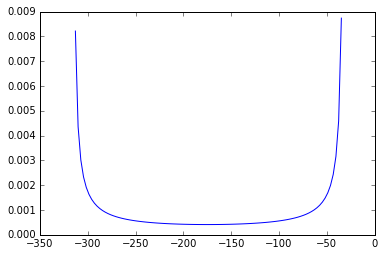

In [22]:
# random cf 
df=df_good

i=88
mini = df.loc[i, 'loc']
maxi = df.loc[i, 'loc'] + df.loc[i, 'scale']
alpha =  df.loc[i, 'alpha']
beta = df.loc[i, 'beta']
loc=df.loc[i, 'loc']
scale=df.loc[i, 'scale']
xs = np.arange(mini, maxi, (maxi-mini)/100)
plt.plot(xs, sp.stats.beta.pdf(xs, a=alpha,b=beta, loc=loc, scale=scale));

Plot ALL problem cfs:

In [23]:
df=df_bad

plt.figure(figsize=(10,300))
for i in range(0, df.shape[0]):
    ax = plt.subplot(df.shape[0], 1, i+1)
    mini = df.loc[i, 'loc']
    maxi = df.loc[i, 'loc'] + df.loc[i, 'scale']
    alpha =  df.loc[i, 'alpha']
    beta = df.loc[i, 'beta']
    loc=df.loc[i, 'loc']
    scale=df.loc[i, 'scale']
    xs = np.arange(mini, maxi, (maxi-mini)/100)
    plt.plot(xs, sp.stats.beta.pdf(xs, a=alpha,b=beta, loc=loc, scale=scale))

Plot ALL good cfs

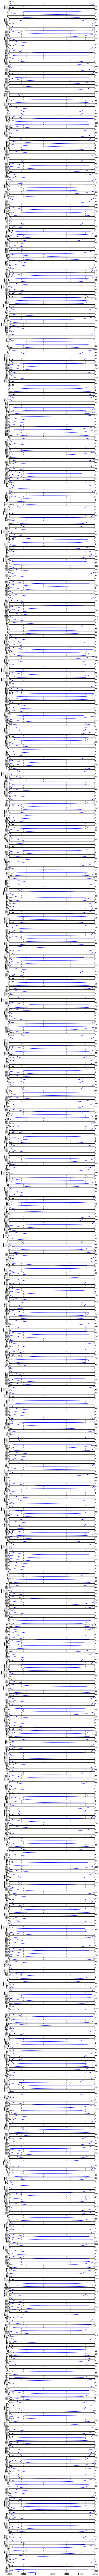

In [24]:
df=df_good

plt.figure(figsize=(10,300))
for i in range(0, df.shape[0]):
    ax = plt.subplot(df.shape[0], 1, i+1)
    mini = df.loc[i, 'loc']
    maxi = df.loc[i, 'loc'] + df.loc[i, 'scale']
    alpha =  df.loc[i, 'alpha']
    beta = df.loc[i, 'beta']
    loc=df.loc[i, 'loc']
    scale=df.loc[i, 'scale']
    xs = np.arange(mini, maxi, (maxi-mini)/100)
    plt.plot(xs, sp.stats.beta.pdf(xs, a=alpha,b=beta, loc=loc, scale=scale))

In [25]:
good_shape=[]

for cf in list_good_generalized_beta:
    if (cf[1]['loc']>1 and cf[1]['shape']>1):
        good_shape.append((cf[0],"Unimodal"))
    elif (cf[1]['loc']<1 and cf[1]['shape']<1):
        good_shape.append((cf[0],"U shape"))
    elif (cf[1]['loc']>1 and cf[1]['shape']<=1):
        good_shape.append((cf[0],"J shape"))
    elif (cf[1]['loc']<=1 and cf[1]['shape']>1):
        good_shape.append((cf[0],"J shape inv"))
    else:
        good_shape.append((cf[0],"error"))

all_good_shapes=[]
for shape in good_shape:
    all_good_shapes.append(shape[1])

unique_good_shape=set(all_good_shapes)
unique_good_shape

{'J shape', 'J shape inv', 'U shape', 'Unimodal'}

In [26]:
bad_shape=[]
bad_U_shape=[]

for cf in list_error_generalized_beta:
    if (cf[1]['loc']>1 and cf[1]['shape']>1):
        bad_shape.append((cf[0],"Unimodal"))
    elif (cf[1]['loc']<1 and cf[1]['shape']<1):
        bad_shape.append((cf[0],"U shape"))
        bad_U_shape.append(cf)
    elif (cf[1]['loc']>1 and cf[1]['shape']<=1):
        bad_shape.append((cf[0],"J shape"))
    elif (cf[1]['loc']<=1 and cf[1]['shape']>1):
        bad_shape.append((cf[0],"J shape inv"))
    else:
        badd_shape.append((cf[0],"error"))

all_bad_shapes=[]
for shape in bad_shape:
    all_bad_shapes.append(shape[1])

unique_bad_shape=set(all_bad_shapes)
unique_bad_shape

set()

In [73]:
df_bad_U_shape = pd.DataFrame(columns = ['method', 'flow', 'amount', 'loc', 'maximum', 'minimum', 'shape', 'uncertainty type'])

for i, cf in enumerate(bad_U_shape):
    df_bad_U_shape.loc[i, 'method'] = cf[0][0]
    df_bad_U_shape.loc[i, 'flow'] = cf[0][1]
    for k in cf[1].keys():
        df_bad_U_shape.loc[i, k] = cf[1][k]

df_bad_U_shape


method  \
0    Land transformation, biodiversity, GLO, with u...   
1    Land transformation, biodiversity, GLO, with u...   
2      Land occupation, biodiversity, GLO, with uncert   
3    Land transformation, biodiversity, GLO, with u...   
4      Land occupation, biodiversity, GLO, with uncert   
5    Land transformation, biodiversity, GLO, with u...   
6    Land transformation, biodiversity, GLO, with u...   
7    Land transformation, biodiversity, GLO, with u...   
8    Land transformation, biodiversity, GLO, with u...   
9    Land transformation, biodiversity, GLO, with u...   
10   Land transformation, biodiversity, GLO, with u...   
11     Land occupation, biodiversity, GLO, with uncert   
12   Land transformation, biodiversity, GLO, with u...   
13   Land transformation, biodiversity, GLO, with u...   
14   Land transformation, biodiversity, GLO, with u...   
15   Land transformation, biodiversity, GLO, with u...   
16   Land transformation, biodiversity, GLO, with u...   
17   Land transformation, biodiversity, GLO, with u...   
18   Land transformation, biodiversity, GLO, with u...   
19   Land transformation, biodiversity, GLO, with u...   
20   Land transformation, biodiversity, GLO, with u...   
21   Land transformation, biodiversity, GLO, with u...   
22   Land transformation, biodiversity, GLO, with u...   
23   Land transformation, biodiversity, GLO, with u...   
24   Land transformation, biodiversity, GLO, with u...   
25   Land transformation, biodiversity, GLO, with u...   
26   Land transformation, biodiversity, GLO, with u...   
27     Land occupation, biodiversity, GLO, with uncert   
28   Land transformation, biodiversity, GLO, with u...   
29   Land transformation, biodiversity, GLO, with u...   
..                                                 ...   
261  Land transformation, biodiversity, GLO, with u...   
262  Land transformation, biodiversity, GLO, with u...   
263  Land transformation, biodiversity, GLO, with u...   
264    Land occupation, biodiversity, GLO, with uncert   
265    Land occupation, biodiversity, GLO, with uncert   
266    Land occupation, biodiversity, GLO, with uncert   
267    Land occupation, biodiversity, GLO, with uncert   
268    Land occupation, biodiversity, GLO, with uncert   
269  Land transformation, biodiversity, GLO, with u...   
270  Land transformation, biodiversity, GLO, with u...   
271    Land occupation, biodiversity, GLO, with uncert   
272  Land transformation, biodiversity, GLO, with u...   
273    Land occupation, biodiversity, GLO, with uncert   
274  Land transformation, biodiversity, GLO, with u...   
275    Land occupation, biodiversity, GLO, with uncert   
276    Land occupation, biodiversity, GLO, with uncert   
277  Land transformation, biodiversity, GLO, with u...   
278    Land occupation, biodiversity, GLO, with uncert   
279  Land transformation, biodiversity, GLO, with u...   
280  Land transformation, biodiversity, GLO, with u...   
281  Land transformation, biodiversity, GLO, with u...   
282    Land occupation, biodiversity, GLO, with uncert   
283  Land transformation, biodiversity, GLO, with u...   
284    Land occupation, biodiversity, GLO, with uncert   
285  Land transformation, biodiversity, GLO, with u...   
286  Land transformation, biodiversity, GLO, with u...   
287  Land transformation, biodiversity, GLO, with u...   
288  Land transformation, biodiversity, GLO, with u...   
289  Land transformation, biodiversity, GLO, with u...   
290  Land transformation, biodiversity, GLO, with u...   

                                     flow    amount        loc  maximum  \
0    ea3bc981-8a35-40e1-82bd-33a12820f98c   12.8666   2.73e-16  41.6751   
1    7381c88b-dc3f-4aff-9ae7-261b8216fac2   253.282   0.224562  315.787   
2    3b4db191-9634-4a01-a873-f3cb234785e4  0.415357    5.8e-16      0.5   
3    6f0c79d3-c980-4cd5-ae0a-51f7d9a5f472  -168.891   1.03e-14 -166.204   
4    56ec994a-eb96-42e8-93eb-4970e30e6362  0.415357    5.8e-16      0.5   
5

In [74]:
len(df_bad_U_shape)

291

### Check "good" beta distributions

In [27]:
cf_with_beta = []
for k in iw_uncert_dict_beta.keys():
    try:
        if iw_uncert_dict_beta[k]['uncertainty type']==13:
            cf_with_beta.append(k)
    except TypeError:
        pass

In [28]:
bad_cfs = [cf[0] for cf in list_error_generalized_beta]
cf_with_beta_good = [cf for cf in cf_with_beta if cf not in bad_cfs]
cf_with_beta_good

[('Land occupation, biodiversity, GLO, with uncert',
  '3b4db191-9634-4a01-a873-f3cb234785e4'),
 ('Terrestrial acidification, GLO, with uncert',
  'aeb3e625-906a-4993-9f02-785f8cfd1ea5'),
 ('Land transformation, biodiversity, GLO, with uncert',
  'bc55a5b7-5a07-4ba7-87af-6f374d79ef06'),
 ('Land occupation, biodiversity, GLO, with uncert',
  'a029c026-6970-40a0-b597-5ebd8dfbaa97'),
 ('Land occupation, biodiversity, GLO, with uncert',
  '16df4fdf-06a1-4c84-bd49-b933d5bd2714'),
 ('Land transformation, biodiversity, GLO, with uncert',
  '19f7928a-99ea-4206-b957-f06834edeb1b'),
 ('Water availability, human health, GLO, with uncert',
  'bb15f4ab-42e1-4f4a-8e48-3a3fb9d90155'),
 ('Land transformation, biodiversity, GLO, with uncert',
  '366ece56-e09c-4acd-b615-aaedd9bbe777'),
 ('Land occupation, biodiversity, GLO, with uncert',
  '56ec994a-eb96-42e8-93eb-4970e30e6362'),
 ('Water availability, human health, GLO, with uncert',
  '341e910f-3799-3a3c-82e9-0ef26c78fd07'),
 ('Water availability, hum

In [29]:
def generate_graph_for_some_random_good_beta(beta_index):
    random_good_cf = cf_with_beta_good[beta_index]
    # For stats-arrays
    random_beta_dict = iw_uncert_dict_beta[random_good_cf]
    del random_beta_dict['uncertainty type']                            # MISSING THE UNDERSCORE!!!
    random_beta_dict['uncertainty_type']=13
    random_good_beta_params = stats_arrays.UncertaintyBase.from_dicts(random_beta_dict)
    random_rng = stats_arrays.MCRandomNumberGenerator(random_good_beta_params)
    stats_array_sample = np.array([random_rng.next() for _ in range(2000)]).flatten()
    # For scipy:
    alpha = random_beta_dict['loc']
    beta = random_beta_dict['shape']
    loc = random_beta_dict['minimum']
    scale = random_beta_dict['maximum'] - random_beta_dict['minimum']
    #For plot
    xs = np.arange(random_beta_dict['minimum'], random_beta_dict['maximum'], scale/200)
    fig, ax = plt.subplots(1, 1)
    ax.hist(stats_array_sample, bins=200, histtype='step', normed=True, label='hist')
    ax.plot(xs, sp.stats.beta.pdf(xs, alpha, beta, loc=loc, scale=scale), lw=5, label='pdf')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    return ax

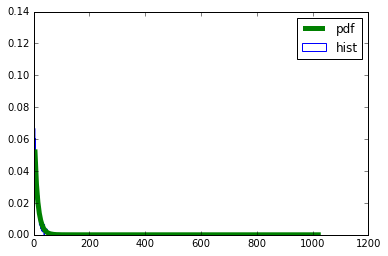

In [30]:
generate_graph_for_some_random_good_beta(1)

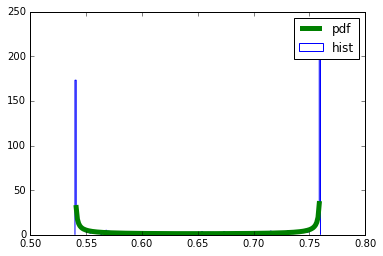

In [31]:
generate_graph_for_some_random_good_beta(30)

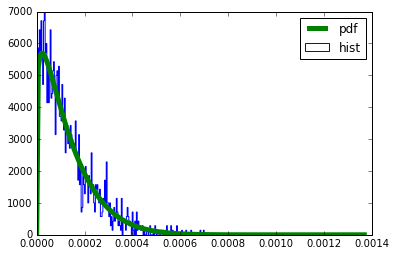

In [32]:
generate_graph_for_some_random_good_beta(77)

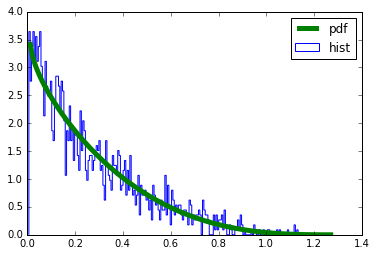

In [33]:
generate_graph_for_some_random_good_beta(99)

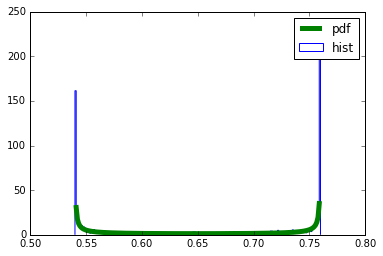

In [34]:
generate_graph_for_some_random_good_beta(111)

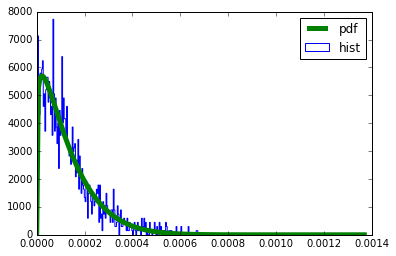

In [35]:
generate_graph_for_some_random_good_beta(133)

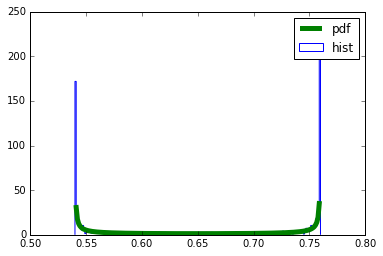

In [36]:
generate_graph_for_some_random_good_beta(200)

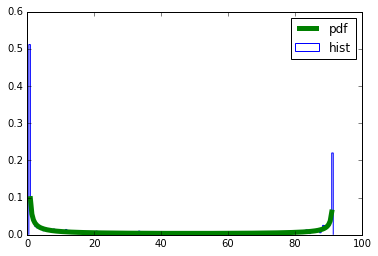

In [37]:
generate_graph_for_some_random_good_beta(210)

# Testing code steps by steps bounded_random_variable

In [38]:
uncert_dict=list_error_generalized_beta[100][1]
params=UncertaintyBase.from_dicts(uncert_dict)
size=1
seed=None
seeded_random=np.random.RandomState(seed)
maximum_iterations=100

uncert_dict, params

IndexError: list index out of range

In [127]:
cls=stats_arrays.GeneralizedBetaUncertainty

In [135]:
data = cls.random_variables(params, size, seeded_random)
min_array = params['minimum'].reshape(params.shape[0], 1)
max_array = params['maximum'].reshape(params.shape[0], 1)

bounds_mask = (data < min_array) + (data > max_array)
counter = 0
while bounds_mask.sum() > 0:
    data[bounds_mask] = cls.random_variables(params,size, seeded_random)[bounds_mask]
    bounds_mask = (data < min_array) + (data > max_array)

    counter += 1
    if counter >= maximum_iterations:
        raise MaximumIterationsError
data

array([[  5.41529774e-05]])